In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [3]:
df = pd.read_csv(url,index_col=None)
df=df.drop(['Lat','Long'],axis=1)
df=df.set_index([*df.columns[:2]])
df=df.stack().reset_index()
df.columns=['state','country','date','cases']
df.date=pd.to_datetime(df.date)
df.head()

,state,country,date,cases
0,Anhui,Mainland China,2020-01-22,1
1,Anhui,Mainland China,2020-01-23,9
2,Anhui,Mainland China,2020-01-24,15
3,Anhui,Mainland China,2020-01-25,39
4,Anhui,Mainland China,2020-01-26,60


In [4]:
plotCountries=['Germany','Italy','France','Spain','Iran','South Korea']
ix=df.country.isin(plotCountries)

Text(0.5,1,'Cases, log y scale')

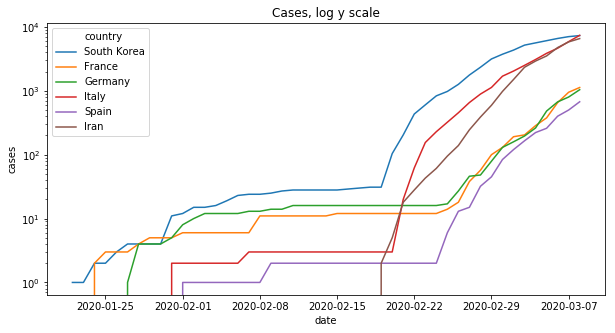

In [5]:
plt.subplots(figsize=(10,5))
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country')

ax = g.axes
ax.set_yscale('log')
plt.title('Cases, log y scale')

Note similar slopes of european countries. Italy took of earlier

Text(0.5,1,'Cases')

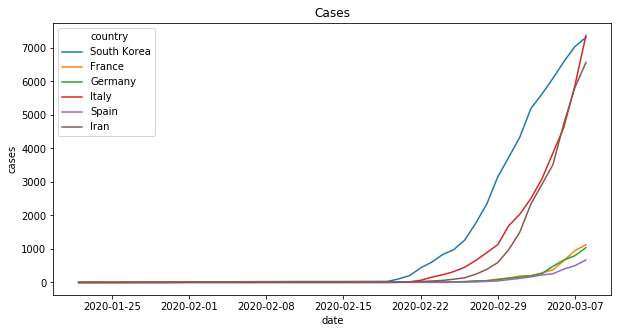

In [7]:
plt.subplots(figsize=(10,5))
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country')

plt.title('Cases')